In [37]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
sys.path.append('/content/drive/My Drive/ENM_5320_Final_Project')
path = "/content/drive/My Drive/ENM_5320_Final_Project"
os.chdir(path)

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
from pathlib import Path
from IPython.display import clear_output
import ipywidgets as widgets
from time import sleep
from tqdm import trange
import wandb
import datetime

from FNO import FNO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# global parameters
B = 15 # batch size
nx = 500 # npts
n_sols = 5000

modes = 50
num_fourier_layers = 4
in_channels = 4
out_channels = 3
fourier_channels = 64
activation = nn.Tanh()
epochs = 1000 # epochs = 10000

checkpt_path = path+'/checkpoints/'
data_path=path+'/data/'

In [39]:
with open(data_path+f"{n_sols}_inputs_train.pkl", 'rb') as file:
    inputs_test = pkl.load(file)
len(inputs_test)
# inputs_test[0]

3750

# Initialize Data Loader

In [40]:
class SodShockData(Dataset):
    def __init__(self, path, n_sols, split: str = "train"):
        super(SodShockData, self).__init__()
        with open(Path(path) / f"{n_sols}_inputs_{split}.pkl", 'rb') as file:
            self.input_data = np.array(pkl.load(file))

        with open(Path(path) / f"{n_sols}_outputs_{split}.pkl", 'rb') as file:
            self.output_data = np.array(pkl.load(file))

        self.train_input_means=[]
        self.train_input_stds=[]
        self.train_output_means=[]
        self.train_output_stds=[]
    def __len__(self):
        return len(self.input_data)

    def normalize_training_data(self):

      for i in range(len(self.input_data[0])):
        mean = self.input_data[:][i].mean()
        std = self.input_data[:][i].std()
        # ensure numerical stability
        if std <= 1e-10:
          std += 1e-6
        self.input_data[:,i] = (self.input_data[:,i]-mean)/std
        self.train_input_means.append(mean)
        self.train_input_stds.append(std)

      for i in range(len(self.output_data[0])):
        mean = self.output_data[:][i].mean()
        std = self.output_data[:][i].std()

        # ensure numerical stability
        if std <= 1e-10:
          std += 1e-6
        self.output_data[:][i] = (self.output_data[:][i]-mean)/std
        self.train_output_means.append(mean)
        self.train_output_stds.append(std)

    def normalize_test_data(self, train_input_means, train_input_stds, train_output_means, train_output_stds):
      for i in range(len(self.input_data[0])):
        mean = train_input_means[i]
        std = train_input_stds[i]
        self.input_data[:][i] = (self.input_data[:][i]-mean)/std

      for i in range(len(self.output_data[0])):
        mean = train_output_means[i]
        std = train_output_stds[i]
        self.output_data[:][i] = (self.output_data[:][i]-mean)/std

    def unnormalize_training_data(self):
      for i in range(len(self.input_data[0])):
        mean = self.train_input_means[i]
        std = self.train_input_stds[i]
        self.input_data[:][i] = self.input_data[:][i]*std + mean

      for i in range(len(self.output_data[0])):
        mean = self.train_output_means[i]
        std = self.train_output_stds[i]
        self.output_data[:][i] = self.output_data[:][i]*std + mean

    def unnormalize_test_data(self, train_input_means, train_input_stds, train_output_means, train_output_stds):
      for i in range(len(self.input_data[0])):
        mean = train_input_means[i]
        std = train_input_stds[i]
        self.input_data[:][i] = self.input_data[:][i]*std + mean

      for i in range(len(self.output_data[0])):
        mean = train_output_means[i]
        std = train_output_stds[i]
        self.output_data[:][i] = self.output_data[:][i]*std + mean


    def __getitem__(self, idx:int):
        inp = self.input_data[idx]
        x, p, rho, u = inp
        input_data = torch.stack((torch.as_tensor(x),torch.as_tensor(p),
                                  torch.as_tensor(rho),torch.as_tensor(u)), dim=-1)

        out = self.output_data[idx]
        p, rho, u = out
        output_data = torch.stack((torch.as_tensor(p),torch.as_tensor(rho),
                                   torch.as_tensor(u)), dim=-1)
        return (input_data.float().to(device), output_data.float().to(device))

In [41]:
train_dataset = SodShockData(
    path=data_path,
    n_sols=n_sols,
    split="train",
)

#train_dataset.normalize_training_data()

train_loader = DataLoader(
    train_dataset,
    batch_size=B,
    shuffle=True,
)
len(train_dataset)


test_dataset = SodShockData(
    path=data_path,
    n_sols=n_sols,
    split="test",
)

#test_dataset.normalize_test_data(train_dataset.train_input_means, train_dataset.train_input_stds, train_dataset.train_output_means, train_dataset.train_output_stds)

test_loader = DataLoader(
    test_dataset,
    batch_size=B,
    shuffle=True,
)
len(test_dataset)

1250

In [ ]:
input_data, output_data = train_dataset[0]
input_data.shape
#print(input_data.shape)
#print(output_data.shape)
torch.as_tensor(train_dataset.input_data).shape
#input_data[:,1]
#output_data[:,0]

torch.Size([3750, 4, 500])

In [ ]:
import torch.nn.functional as F
x = torch.as_tensor(train_dataset.input_data)
padding=1

print(x[0].shape)

x = F.pad(x, [0, padding])
x=x.permute(0, 2, 1)

print(x[0].shape)

x=x.permute(0, 2, 1)
x = x[...,:-padding]

print(x[0].shape)

torch.Size([4, 500])
torch.Size([501, 4])
torch.Size([4, 500])


In [ ]:
for batch in train_loader:
    inputs, outputs = batch
    print(inputs.shape)
    # print(outputs)
    break

torch.Size([15, 500, 4])


In [ ]:
"""def model_train(model, train_loader, optimizer, loss_fn, epochs):

    wandb.init(project="ENM_5320_Project", name="fno-training", reinit="create_new")

    # Log model configuration to wandb
    wandb.config.update({
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "loss_function": type(loss_fn).__name__,
        # Add other relevant model parameters here
    })

    # Watch model for gradients and parameters logging
    wandb.watch(model, log="all", log_freq=100)

    # Training loop
    for epoch in trange(epochs):
        for batch in train_loader:
            inputs, outputs = batch
            pred = model(inputs)

            loss = loss_fn(pred, outputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0 or epoch == epochs:
            wandb.log({"train_loss": loss})
            if epoch % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss}')

    # Finish wandb run
    wandb.finish()
    save_checkpoint(model, optimizer, epoch, "fno")
    return model.state_dict(), optimizer.state_dict()"""

'def model_train(model, train_loader, optimizer, loss_fn, epochs):\n\n    wandb.init(project="ENM_5320_Project", name="fno-training", reinit="create_new")\n\n    # Log model configuration to wandb\n    wandb.config.update({\n        "learning_rate": optimizer.param_groups[0][\'lr\'],\n        "epochs": epochs,\n        "batch_size": train_loader.batch_size,\n        "loss_function": type(loss_fn).__name__,\n        # Add other relevant model parameters here\n    })\n\n    # Watch model for gradients and parameters logging\n    wandb.watch(model, log="all", log_freq=100)\n\n    # Training loop\n    for epoch in trange(epochs):\n        for batch in train_loader:\n            inputs, outputs = batch\n            pred = model(inputs)\n\n            loss = loss_fn(pred, outputs)\n\n            optimizer.zero_grad()\n            loss.backward()\n            optimizer.step()\n\n        if epoch % 20 == 0 or epoch == epochs:\n            wandb.log({"train_loss": loss})\n            if epoch %

# Train and Save Model

In [4]:
# model initialization
model = FNO(modes=modes, num_fourier_layers=num_fourier_layers, in_channels=in_channels, hidden_channels=num_fourier_layers, out_channels=out_channels, activation=activation).to(device)

# initialize optimizer
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
l = nn.MSELoss()

In [ ]:

#model_state, optimizer_state = model_train(model, train_loader, optimizer, l, epochs)
train_loss_log = []
test_loss_log=[]

for epoch in trange(epochs):
    train_losses = []
    for batch in train_loader:
        inputs, outputs = batch
        pred = model(inputs)


        train_loss = l(pred, outputs)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.detach().cpu().item())
        # print(loss)
        #zero_grad
        #backwards
        #step
        # print(inputs.shape, outputs.shape)
    if epoch % 1 == 0 or epoch == epochs:
        train_loss_log.append(np.mean(train_losses))
        test_losses=[]
        with torch.no_grad():
          for batch in test_loader:
            inputs, outputs = batch
            pred = model(inputs)
            test_loss = l(pred, outputs)
            test_losses.append(test_loss.detach().cpu().item())
        test_loss_log.append(np.mean(test_losses))
        if epoch % 100 == 0 or epoch == epochs:
          print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss}')
          print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {test_loss}')


  0%|          | 1/1000 [00:03<55:28,  3.33s/it]

Epoch [1/1000], Training Loss: 0.16606742143630981
Epoch [1/1000], Validation Loss: 0.1390627920627594


 10%|█         | 101/1000 [04:28<39:46,  2.65s/it]

Epoch [101/1000], Training Loss: 0.0004786050121765584
Epoch [101/1000], Validation Loss: 0.0005855995113961399


 20%|██        | 201/1000 [08:52<34:27,  2.59s/it]

Epoch [201/1000], Training Loss: 0.00028626591665670276
Epoch [201/1000], Validation Loss: 0.0009248750284314156


 30%|███       | 301/1000 [13:16<29:42,  2.55s/it]

Epoch [301/1000], Training Loss: 0.0003880552831105888
Epoch [301/1000], Validation Loss: 0.0003253749164287001


 40%|████      | 401/1000 [17:39<25:13,  2.53s/it]

Epoch [401/1000], Training Loss: 0.00046574496082030237
Epoch [401/1000], Validation Loss: 0.0009409753256477416


 50%|█████     | 501/1000 [22:03<21:50,  2.63s/it]

Epoch [501/1000], Training Loss: 0.00028684441349469125
Epoch [501/1000], Validation Loss: 6.496576679637656e-05


 60%|██████    | 601/1000 [26:25<18:09,  2.73s/it]

Epoch [601/1000], Training Loss: 0.00014178515993990004
Epoch [601/1000], Validation Loss: 6.357550591928884e-05


 70%|███████   | 701/1000 [30:52<13:38,  2.74s/it]

Epoch [701/1000], Training Loss: 0.00010023463983088732
Epoch [701/1000], Validation Loss: 0.0002817154163494706


 80%|████████  | 801/1000 [35:21<08:36,  2.59s/it]

Epoch [801/1000], Training Loss: 8.379665814572945e-05
Epoch [801/1000], Validation Loss: 0.00025977875338867307


 90%|█████████ | 901/1000 [39:47<04:13,  2.56s/it]

Epoch [901/1000], Training Loss: 0.00019838260777760297
Epoch [901/1000], Validation Loss: 7.182455010479316e-05


100%|██████████| 1000/1000 [44:13<00:00,  2.65s/it]


In [ ]:
from google.colab import files
import helper
checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
        'train_loss_log': train_loss_log,
        'test_loss_log': test_loss_log
    }


checkpt_file = (f'{modes}_modes_{n_sols}_n_sols_{epoch+1}_epochs_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.pt')
torch.save(checkpoint, checkpt_path+checkpt_file)
files.download(checkpt_path+checkpt_file)


FileNotFoundError: Cannot find file: 50_modes_5000_n_sols_1000_epochs_20250508_215024.pt

# Load Model

In [5]:
# checkpt_file="24_modes500_n_sols_fno_unnormalized_999.pt"
# checkpt_file="50_modes_500_n_sols_4509_epochs_20250508_210225.pt"
checkpt_file="50_modes_5000_n_sols_1000_epochs_20250508_215024.pt"
checkpoint=torch.load(checkpt_path+checkpt_file, weights_only=False, map_location=torch.device('cpu')) # only need this map_location if on cpu only

model=FNO(modes=modes, num_fourier_layers=num_fourier_layers, in_channels=in_channels, hidden_channels=num_fourier_layers, out_channels=out_channels, activation=activation).to(device)

model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer_state'])
# epoch=checkpoint['epoch']
train_loss_log=checkpoint['train_loss_log']
test_loss_log=checkpoint['test_loss_log']

#model.state_dict()
#checkpoint['model_state']

## Un-Normalize Data

In [ ]:
#train_input_means = train_dataset.train_input_means
#train_input_stds = train_dataset.train_input_stds

#train_output_means = train_dataset.train_output_means
#train_output_stds = train_dataset.train_output_stds

#train_dataset.unnormalize_training_data()
#test_dataset.unnormalize_test_data(train_dataset.train_input_means, train_dataset.train_input_stds, train_dataset.train_output_means, train_dataset.train_output_stds)

In [ ]:
input_data, output_data = train_dataset[0]
input_data.shape
#print(input_data.shape)
#print(output_data.shape)
torch.as_tensor(train_dataset.input_data).shape
input_data[:,1]

# Plot Training History

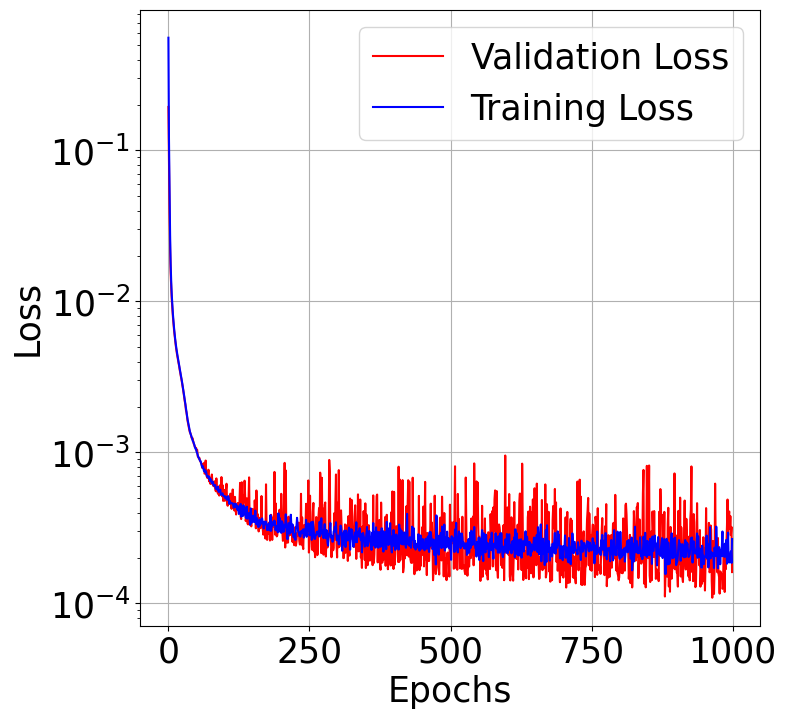

In [13]:
fig, ax = plt.subplots(1, figsize=(8,8))
ax.plot(test_loss_log, label="Validation Loss", c="r")
ax.plot(train_loss_log, label="Training Loss", c="b")
ax.tick_params(axis="both", labelsize=25)
ax.set_yscale("log")
ax.set_ylabel("Loss", fontsize=25)
ax.set_xlabel("Epochs", fontsize=25)
ax.legend(fontsize=25)
ax.grid()
plt.show()
ax.legend()

# Make Predictions and Compare

In [14]:
import random
def plot_random_samples(dataset, num_samples: int, model, split: str):
    dpi=100
    cols=3

    rand_samples = random.sample(list(np.arange(0, len(dataset))), num_samples)
    fig, ax = plt.subplots(num_samples, cols, figsize=(24, 16), dpi=100, sharey=False, sharex=True)
    for i in range(len(rand_samples)):
        rand_sample = rand_samples[i]

        input, output = dataset[rand_sample]
        input = torch.unsqueeze(input, 0)
        output = torch.unsqueeze(output, 0)

        #print(input.shape)
        #print(input.shape)
        pred = model(input)
        pred = torch.squeeze(pred, 0)

        input = torch.squeeze(input, 0)
        output = torch.squeeze(output, 0)
        input_x=input[:,0].detach().cpu().numpy()

        input_p=input[:,1].detach().cpu().numpy()
        input_rho=input[:,2].detach().cpu().numpy()
        input_u=input[:,3].detach().cpu().numpy()
        #print(input_p)
        output_p=output[:,0].detach().cpu().numpy()
        output_rho=output[:,1].detach().cpu().numpy()
        output_u=output[:,2].detach().cpu().numpy()

        pred_p=pred[:,0].detach().cpu().numpy()
        pred_rho=pred[:,1].detach().cpu().numpy()
        pred_u=pred[:,2].detach().cpu().numpy()

        ax[i,0].plot(input_x, input_p, label="Initial", c="b", lw=5)
        ax[i,0].plot(input_x, output_p, label="Ground Truth", c="k", lw=5)
        ax[i,0].plot(input_x, pred_p, label="Prediction", c="orange", lw=5)
        ax[i,0].set_title(f"Pressure Profile for {split} Sample_{rand_sample}")
        ax[i, 0].legend()

        ax[i, 1].plot(input_x, input_rho, label="Initial Condition", c="b", lw=5)
        ax[i, 1].plot(input_x, output_rho, label="Ground Truth", c="k", lw=5)
        ax[i, 1].plot(input_x, pred_rho, label="Prediction", c="orange", lw=5)
        ax[i, 1].set_title(f"Density Profile for {split} Sample_{rand_sample}")
        ax[i, 1].legend()

        ax[i, 2].plot(input_x, input_u, label="Initial", c="b", lw=5)
        ax[i, 2].plot(input_x, output_u, label="Ground Truth", c="k", lw=5)
        ax[i, 2].plot(input_x, pred_u, label="Prediction", c="orange", lw=5)
        ax[i, 2].set_title(f"Velocity Profile for {split} Sample_{rand_sample}")
        ax[i, 2].legend()



#fig, ax = plt.subplots(5, 3, figsize=(12, 8), dpi=100)
#ax[0,0].set_title('hi')

In [33]:
def plot_specified_samples(dataset, samples: int, model, split: str):
    dpi=100
    cols=3
    num_samples=len(samples)
    fig, ax = plt.subplots(num_samples, cols, figsize=(32, 24), dpi=100, sharey=False, sharex=True)
    for i in range(num_samples):
        sample = samples[i]

        input, output = dataset[sample]
        input = torch.unsqueeze(input, 0)
        output = torch.unsqueeze(output, 0)

        #print(input.shape)
        #print(input.shape)
        pred = model(input)
        pred = torch.squeeze(pred, 0)

        input = torch.squeeze(input, 0)
        output = torch.squeeze(output, 0)
        input_x=input[:,0].detach().cpu().numpy()

        input_p=input[:,1].detach().cpu().numpy()
        input_rho=input[:,2].detach().cpu().numpy()
        input_u=input[:,3].detach().cpu().numpy()
        #print(input_p)
        output_p=output[:,0].detach().cpu().numpy()
        output_rho=output[:,1].detach().cpu().numpy()
        output_u=output[:,2].detach().cpu().numpy()

        pred_p=pred[:,0].detach().cpu().numpy()
        pred_rho=pred[:,1].detach().cpu().numpy()
        pred_u=pred[:,2].detach().cpu().numpy()

        ax[i, 0].plot(input_x, input_p, label="Initial", c="b", lw=5)
        ax[i, 0].plot(input_x, output_p, label="Ground Truth", c="k", lw=5)
        ax[i, 0].plot(input_x, pred_p, label="Prediction", c="orange", lw=5)
        ax[i, 0].set_title(f"Pressure Profile for {split} Sample_{sample}")
        ax[i, 0].legend()

        ax[i, 1].plot(input_x, input_rho, label="Initial Condition", c="b", lw=5)
        ax[i, 1].plot(input_x, output_rho, label="Ground Truth", c="k", lw=5)
        ax[i, 1].plot(input_x, pred_rho, label="Prediction", c="orange", lw=5)
        ax[i, 1].set_title(f"Density Profile for {split} Sample_{sample}")
        ax[i, 1].legend()

        ax[i, 2].plot(input_x, input_u, label="Initial", c="b", lw=5)
        ax[i, 2].plot(input_x, output_u, label="Ground Truth", c="k", lw=5)
        ax[i, 2].plot(input_x, pred_u, label="Prediction", c="orange", lw=5)
        ax[i, 2].set_title(f"Velocity Profile for {split} Sample_{sample}")
        ax[i, 2].legend()

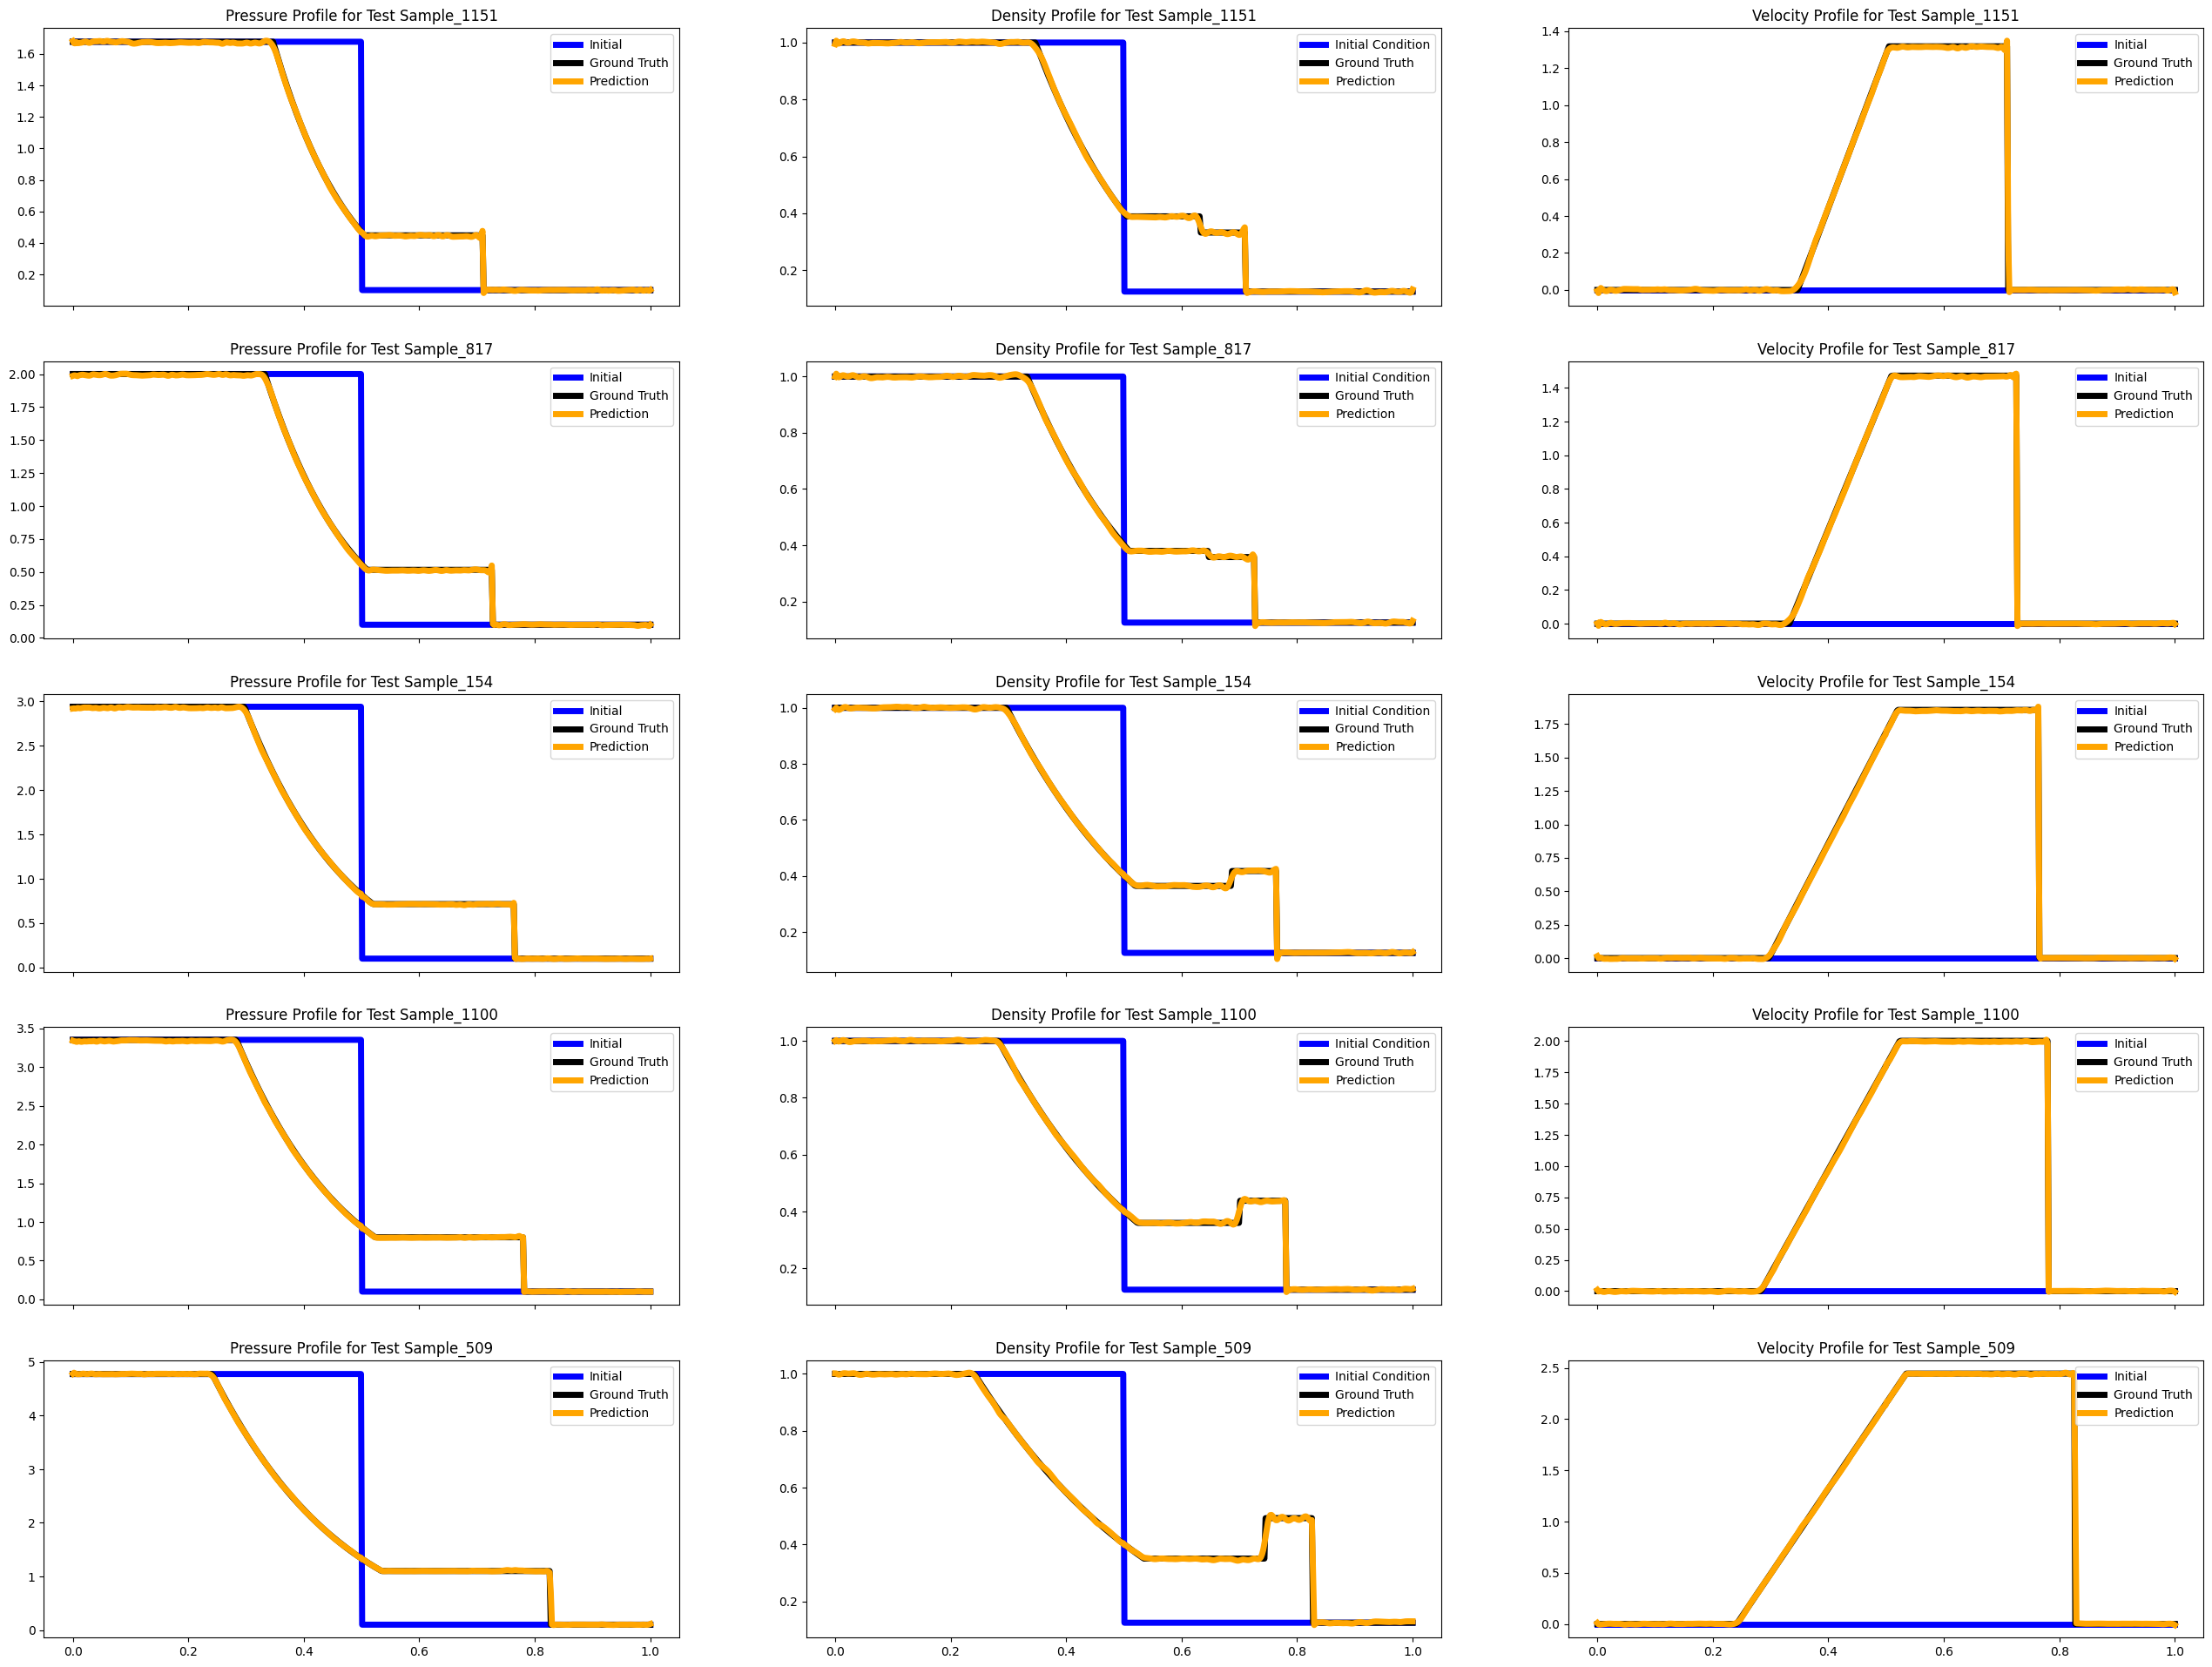

In [35]:
num_samples=5
# plot_random_samples(test_dataset, num_samples=num_samples, model=model, split="Test")
samples=[1151, 817, 154, 1100, 509]
plot_specified_samples(test_dataset, samples=samples, model=model, split="Test")

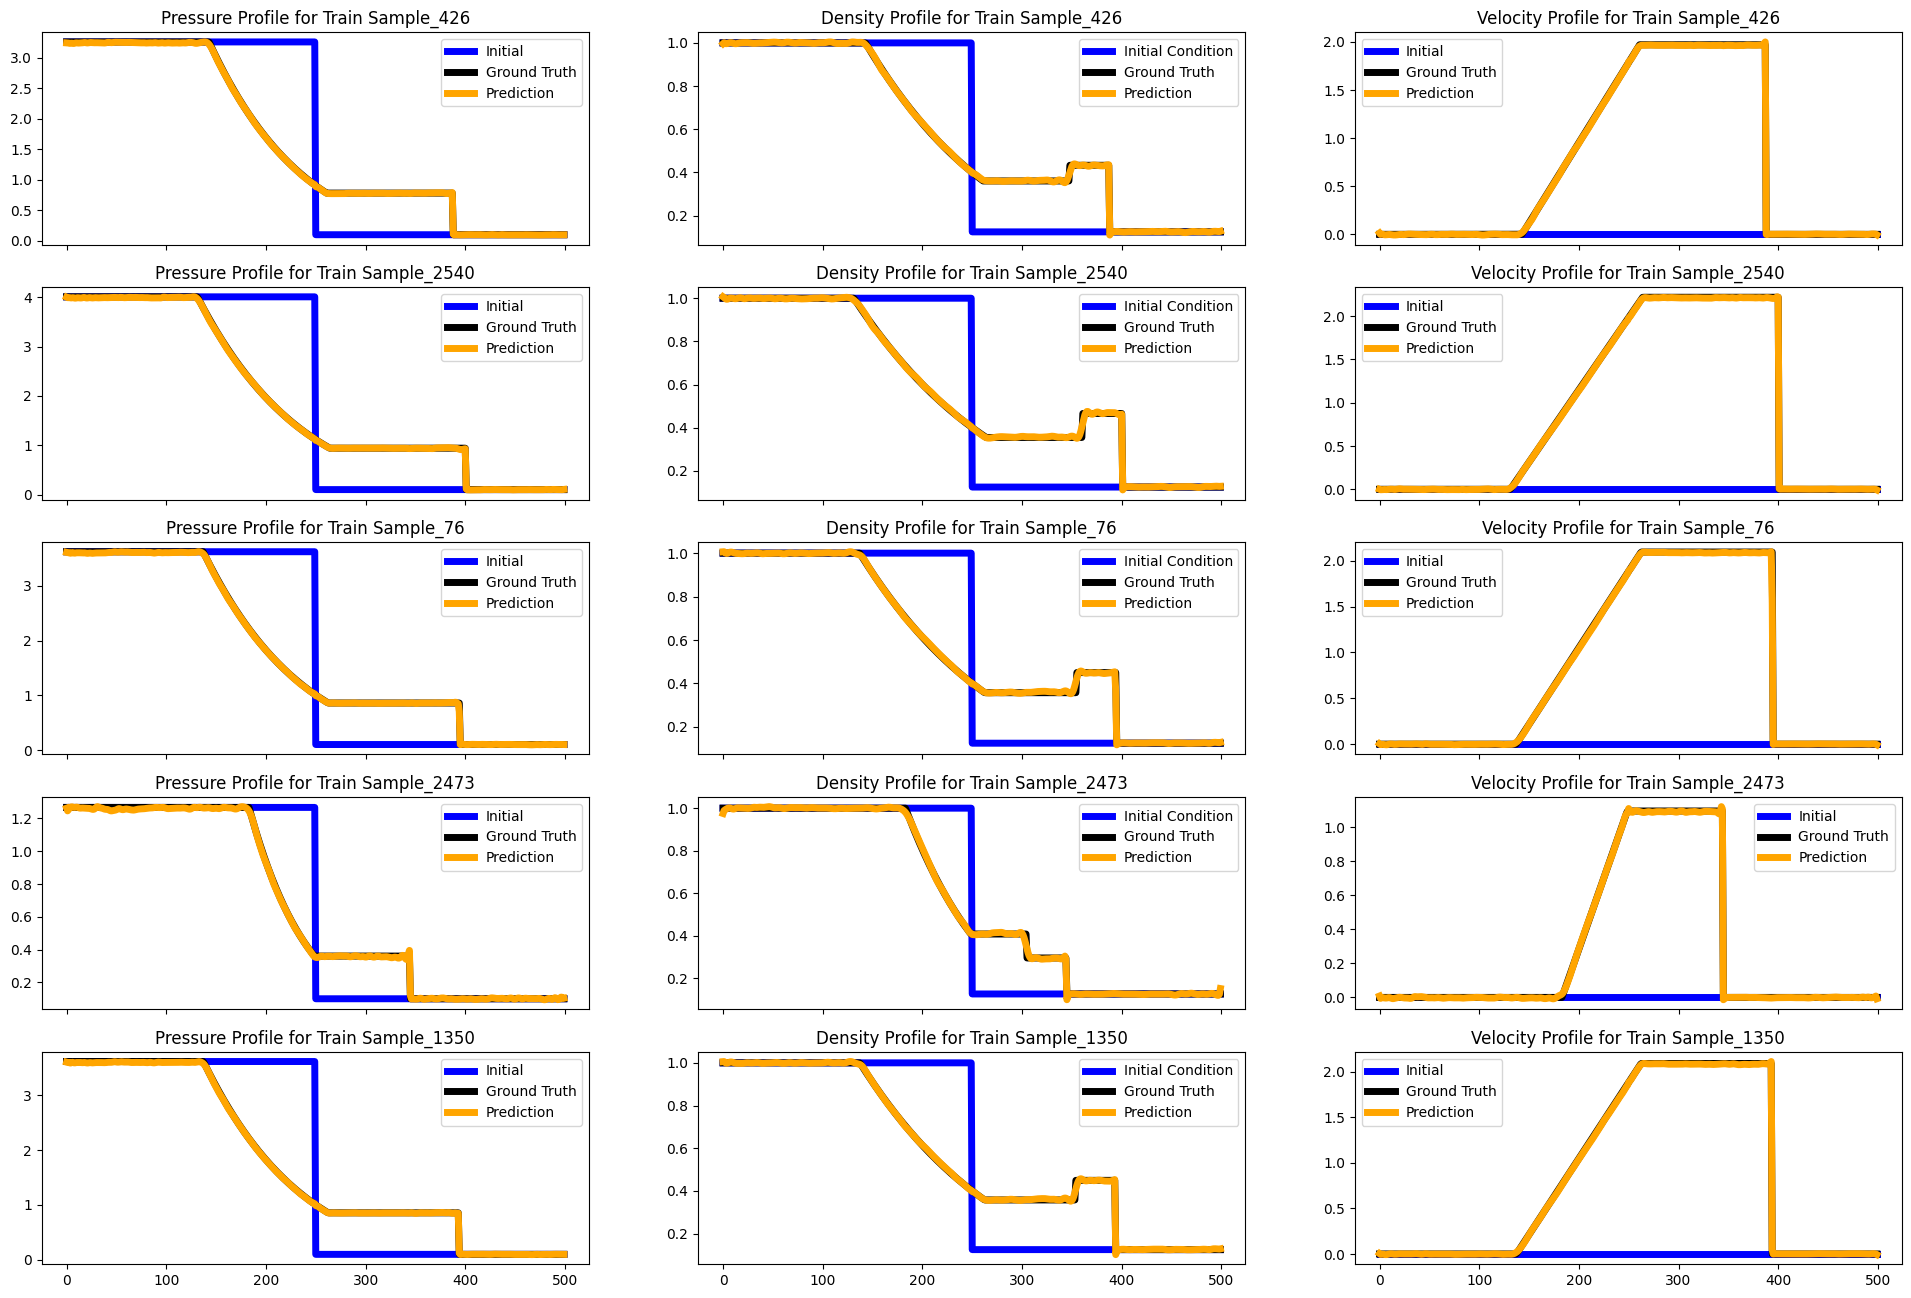

In [34]:
num_samples=5
plot_random_samples(train_dataset, num_samples=num_samples, model=model, split="Train")

# Visualize Performance of Standard Case of 1D Shock Tube

## Find Base Case in Testing or Training Input

In [32]:
base_case=None
for i in range(len(train_dataset.input_data)):
    init_conditions = train_dataset.input_data[i]
    if init_conditions[1][0]==1:
      base_case=i
      print(base_case)
if base_case is None:
  print("Base case not found")

Base case not found


In [46]:
base_case=None
for i in range(len(test_dataset.input_data)):
    init_conditions = test_dataset.input_data[i]
    if init_conditions[1][0]==1:
      base_case=i
      print(base_case)
if base_case is None:
  print("Base case not found")

690


(4, 500)


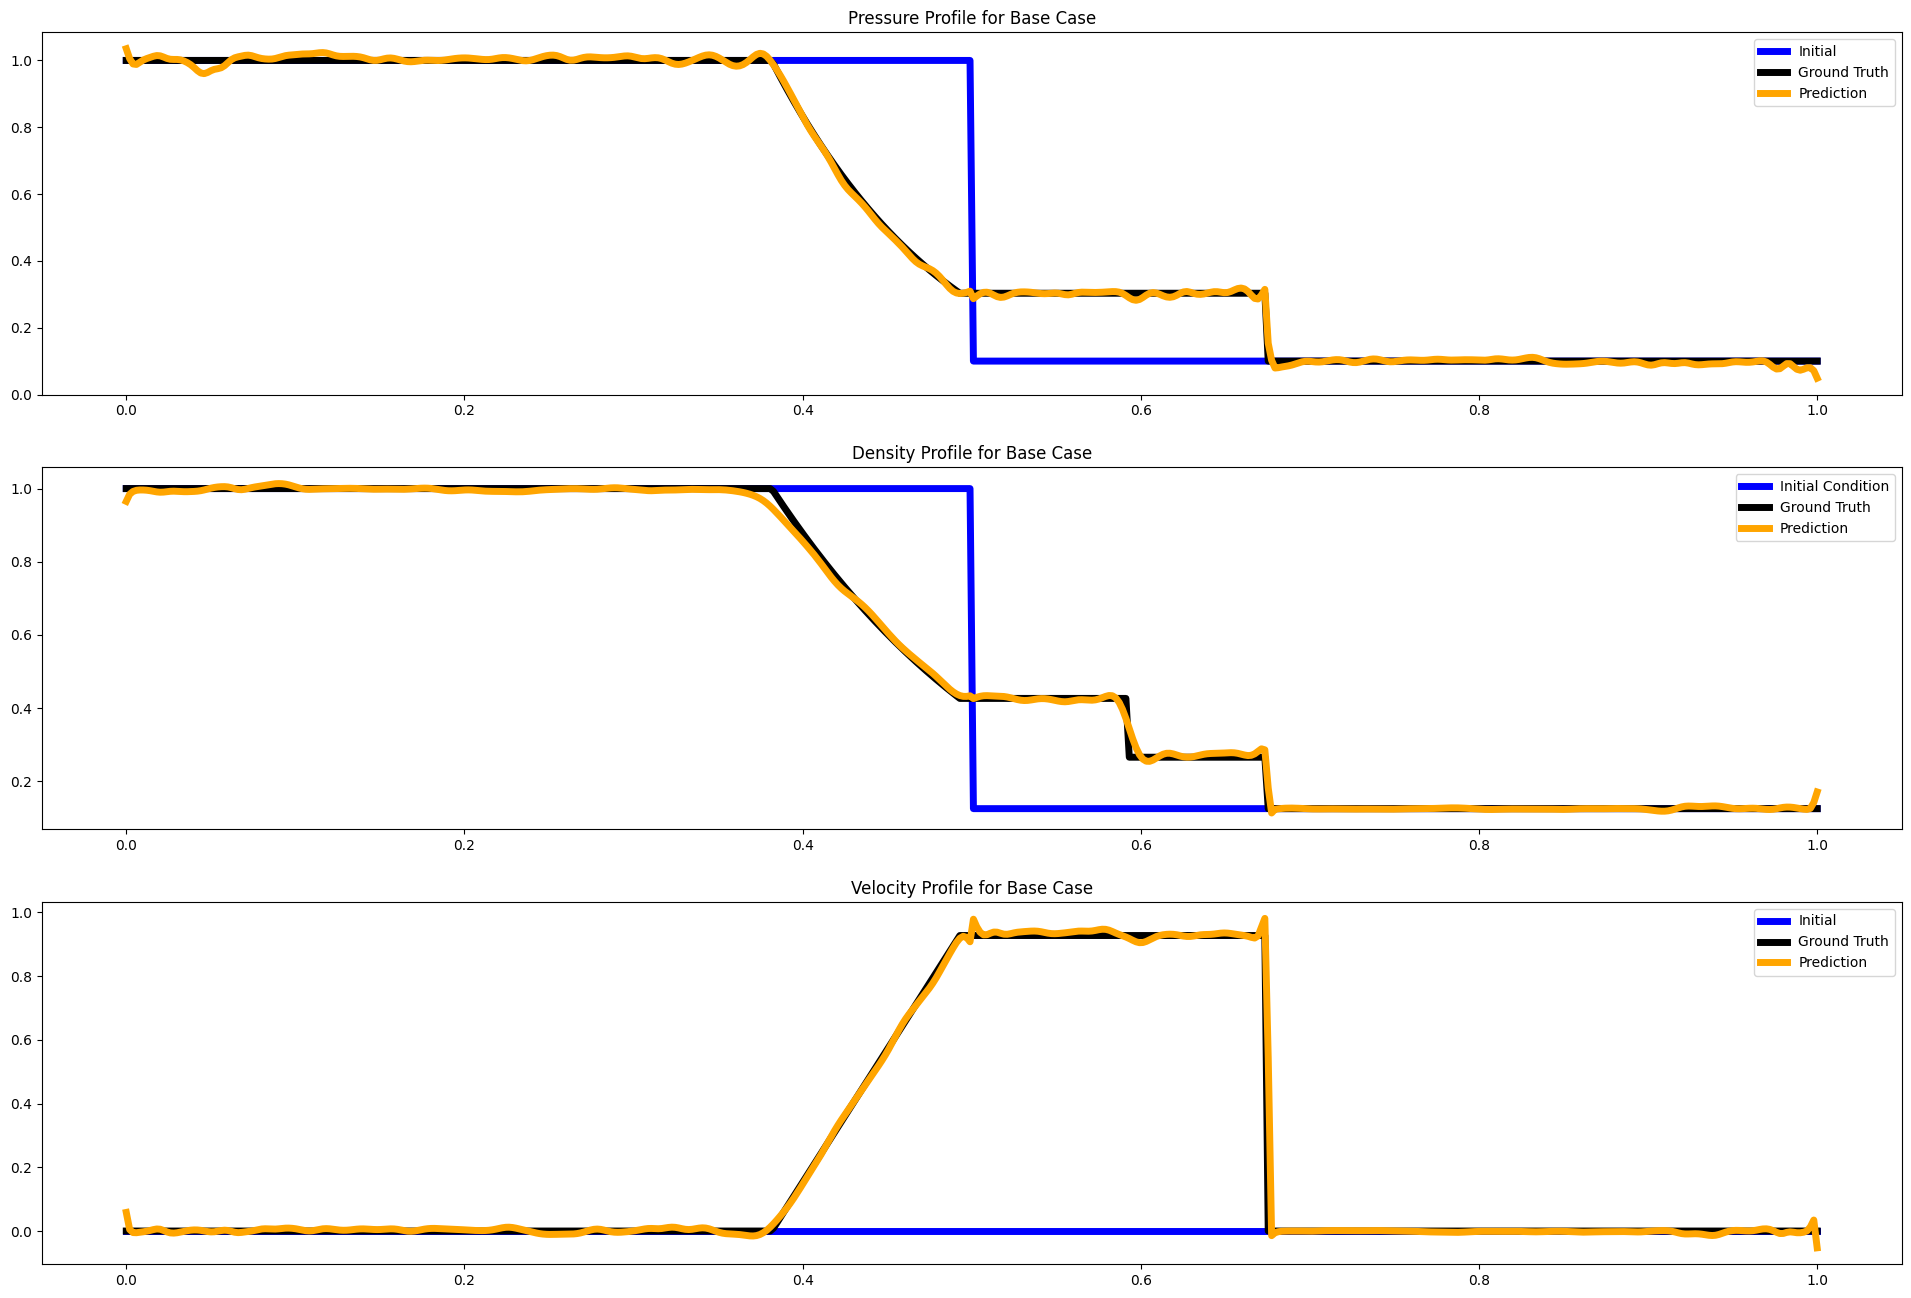

In [49]:
dpi=100
cols=3
print(test_dataset.input_data[base_case].shape)
sample = test_dataset[base_case]
input, output = sample
input = torch.unsqueeze(input, 0)
output = torch.unsqueeze(output, 0)

pred=model(input)
pred=torch.squeeze(pred, 0)

input=torch.squeeze(input,0)
output=torch.squeeze(output,0)
input_x=input[:,0].detach().cpu().numpy()

input_p=input[:,1].detach().cpu().numpy()
input_rho=input[:,2].detach().cpu().numpy()
input_u=input[:,3].detach().cpu().numpy()

output_p=output[:,0].detach().cpu().numpy()
output_rho=output[:,1].detach().cpu().numpy()
output_u=output[:,2].detach().cpu().numpy()

pred_p=pred[:,0].detach().cpu().numpy()
pred_rho=pred[:,1].detach().cpu().numpy()
pred_u=pred[:,2].detach().cpu().numpy()

fig, ax = plt.subplots(3, 1, figsize=(24,16), dpi=100)

ax[0].plot(input_x, input_p, label="Initial", c="b", lw=5)
ax[0].plot(input_x, output_p, label="Ground Truth", c="k", lw=5)
ax[0].plot(input_x, pred_p, label="Prediction", c="orange", lw=5)
ax[0].set_title(f"Pressure Profile for Base Case")
ax[0].legend()

ax[1].plot(input_x, input_rho, label="Initial Condition", c="b", lw=5)
ax[1].plot(input_x, output_rho, label="Ground Truth", c="k", lw=5)
ax[1].plot(input_x, pred_rho, label="Prediction", c="orange", lw=5)
ax[1].set_title(f"Density Profile for Base Case")
ax[1].legend()

ax[2].plot(input_x, input_u, label="Initial", c="b", lw=5)
ax[2].plot(input_x, output_u, label="Ground Truth", c="k", lw=5)
ax[2].plot(input_x, pred_u, label="Prediction", c="orange", lw=5)
ax[2].set_title(f"Velocity Profile for Base Case")
ax[2].legend()


In [ ]:
def activation(name='tanh'):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['SiLU']:
        return nn.SiLU()
    else:
        raise ValueError('Unknown activation function')